In [1]:
pip install scikit-fuzzy


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
pip install paho-mqtt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


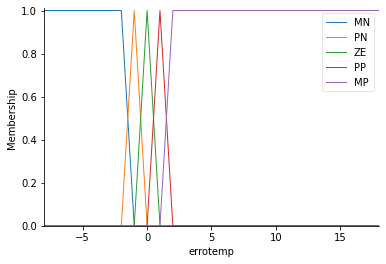

In [4]:
import numpy as np
import skfuzzy as fuzz
import paho.mqtt.client as mqtt
from skfuzzy import control as ctrl
import time

mqttBroker ="test.mosquitto.org"
client = mqtt.Client("c213Inatelsbm")
client.connect(mqttBroker)

# errotemp - funções de pertinência e universo
errotemp = ctrl.Antecedent(np.arange(-8, 19, 1), 'errotemp')
errotemp['MN'] = fuzz.trapmf(errotemp.universe, [-8, -8, -2, -1])
errotemp['PN'] = fuzz.trimf(errotemp.universe, [-2, -1, 0])
errotemp['ZE'] = fuzz.trimf(errotemp.universe, [-1, 0, 1])
errotemp['PP'] = fuzz.trimf(errotemp.universe, [0, 1, 2])
errotemp['MP'] = fuzz.trapmf(errotemp.universe, [1, 2, 18, 18])
errotemp.view()

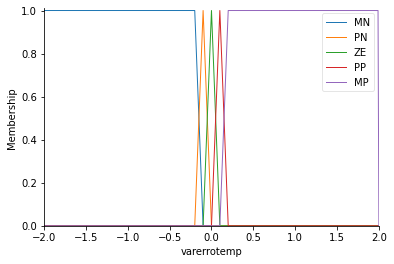

In [5]:
# varrotemp - funções de pertinência e universo
varerrotemp =ctrl.Antecedent(np.arange(-2, 2.01, 0.01), 'varerrotemp')
varerrotemp['MN'] = fuzz.trapmf(varerrotemp.universe, [-2, -2, -0.2,-0.1])
varerrotemp['PN'] = fuzz.trimf(varerrotemp.universe, [-0.2,-0.1,0])
varerrotemp['ZE'] = fuzz.trimf(varerrotemp.universe, [-0.1, 0, 0.1])
varerrotemp['PP'] = fuzz.trimf(varerrotemp.universe, [0, 0.1, 0.2])
varerrotemp['MP'] = fuzz.trapmf(varerrotemp.universe,[0.1, 0.2, 2,2])
varerrotemp.view()

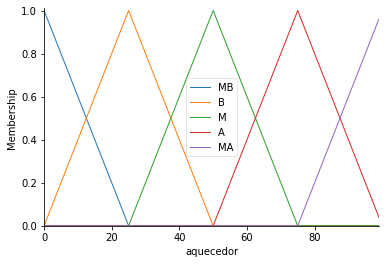

In [6]:
# aquecedor - funções de pertinência e universo
aquecedor =ctrl.Consequent(np.arange(0, 100, 1), 'aquecedor')
aquecedor['MB'] = fuzz.trimf(aquecedor.universe, [0,0,25])
aquecedor['B'] = fuzz.trimf(aquecedor.universe, [0,25,50])
aquecedor['M'] = fuzz.trimf(aquecedor.universe, [25, 50, 75])
aquecedor['A'] = fuzz.trimf(aquecedor.universe, [50, 75, 100])
aquecedor['MA'] = fuzz.trimf(aquecedor.universe, [75, 100, 100])
aquecedor.view()

In [7]:
regra1 = ctrl.Rule(errotemp['MN']& varerrotemp['MN'], aquecedor['MA'])
regra2 = ctrl.Rule(errotemp['PN']& varerrotemp['MN'], aquecedor['MA'])
regra3 = ctrl.Rule(errotemp['ZE']& varerrotemp['MN'], aquecedor['A'])
regra4 = ctrl.Rule(errotemp['PP']& varerrotemp['MN'], aquecedor['M'])
regra5 = ctrl.Rule(errotemp['MP']& varerrotemp['MN'], aquecedor['M'])
regra6 = ctrl.Rule(errotemp['MN']& varerrotemp['PN'], aquecedor['MB'])
regra7 = ctrl.Rule(errotemp['PN']& varerrotemp['PN'], aquecedor['B'])
regra8 = ctrl.Rule(errotemp['ZE']& varerrotemp['PN'], aquecedor['B'])
regra9 = ctrl.Rule(errotemp['PP']& varerrotemp['PN'], aquecedor['A'])
regra10 = ctrl.Rule(errotemp['MP']& varerrotemp['PN'], aquecedor['A'])
regra11 = ctrl.Rule(errotemp['MN']& varerrotemp['ZE'], aquecedor['MA'])
regra12 = ctrl.Rule(errotemp['PN']& varerrotemp['ZE'], aquecedor['A'])
regra13 = ctrl.Rule(errotemp['ZE']& varerrotemp['ZE'], aquecedor['M'])
regra14 = ctrl.Rule(errotemp['PP']& varerrotemp['ZE'], aquecedor['B'])
regra15 = ctrl.Rule(errotemp['MP']& varerrotemp['ZE'], aquecedor['MB'])
regra16 = ctrl.Rule(errotemp['MN']& varerrotemp['PP'], aquecedor['B'])
regra17 = ctrl.Rule(errotemp['PN']& varerrotemp['PP'], aquecedor['B'])
regra18 = ctrl.Rule(errotemp['ZE']& varerrotemp['PP'], aquecedor['M'])
regra19 = ctrl.Rule(errotemp['PP']& varerrotemp['PP'], aquecedor['B'])
regra20 = ctrl.Rule(errotemp['MP']& varerrotemp['PP'], aquecedor['MB'])
regra21 = ctrl.Rule(errotemp['MN']& varerrotemp['MP'], aquecedor['M'])
regra22 = ctrl.Rule(errotemp['PN']& varerrotemp['MP'], aquecedor['M'])
regra23 = ctrl.Rule(errotemp['ZE']& varerrotemp['MP'], aquecedor['B'])
regra24 = ctrl.Rule(errotemp['PP']& varerrotemp['MP'], aquecedor['MB'])
regra25 = ctrl.Rule(errotemp['MP']& varerrotemp['MP'], aquecedor['MB'])

In [8]:
aquecedor_ctrl = ctrl.ControlSystem([regra1, regra2, regra3,regra4,regra5,regra6, regra7, regra8,regra9,regra10,regra11, regra12, regra13,regra14,regra15,regra16, regra17, regra18,regra19,regra20,regra21, regra22, regra23,regra24,regra25])
potencia = ctrl.ControlSystemSimulation(aquecedor_ctrl)

In [10]:
# parâmetros iniciais do sistema
sp=5
tempatual=7
print(sp)
print(tempatual)
erroatual=0
while True: 
  erroanterior=erroatual
  erroatual=tempatual-sp
  varerroTemp=erroatual-erroanterior
  potencia.input['errotemp'] =erroatual
  potencia.input['varerrotemp'] =varerroTemp
  potencia.compute()

  # simulação da temperatura
  i=0
  while (i < 10):
    tempatual=tempatual * 0.9952 + potencia.output['aquecedor'] * 0.0003963
    time.sleep(1)
    i += 1

  # publicação dos resultados via MQTT
  print(tempatual)
  client.publish("Aquecedor/Temperatura", tempatual)
  client.publish("Aquecedor/erro", erroatual)

5
7
6.7196465503208875
6.597906300499674
6.550965245108431
6.422270504727256
6.377321488332774
6.257024393711042
6.229683557654779
6.096498302465776
6.065768530525401
5.948140603032941
5.92893958492161
5.798801400096085
5.7561033973674505
5.6703814742660725
5.620428362176181
5.550176935222649
5.489424090282841
5.424142087959911
5.354019584896501
5.278024197362347
5.194382419592429
5.099926307382545
4.9885369511836535
4.885648520111699
4.763481135063542


KeyboardInterrupt: 